<a href="https://colab.research.google.com/github/tarikCiftci/Machine_learning_projects/blob/main/Fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost

In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,f1_score,precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier  
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler,SMOTE
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

In [ ]:
data = pd.read_csv('/content/application_data.csv')
data1 = data.copy()
data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [ ]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('object')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df
data = reduce_mem_usage(data)

Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 92.38 MB
Decreased by 67.7%


# EDA 
As the dataset is too large, we devide the dataset into 3 part (object,integer,float) based on its datatype and analyze it.

In [ ]:
print("Object type values:",np.count_nonzero(data.select_dtypes('object').columns))
print("___________________________________________________________________________________________")
print(data.select_dtypes('object').columns)
print("___________________________________________________________________________________________")

Object type values: 16
___________________________________________________________________________________________
Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')
___________________________________________________________________________________________


In [ ]:
le = LabelEncoder()
data['NAME_CONTRACT_TYPE'] = le.fit_transform(data['NAME_CONTRACT_TYPE'])
data['CODE_GENDER'] = le.fit_transform(data['CODE_GENDER'])
data['FLAG_OWN_CAR'] = le.fit_transform(data['FLAG_OWN_CAR'])
data['FLAG_OWN_REALTY'] = le.fit_transform(data['FLAG_OWN_REALTY'])
data['NAME_TYPE_SUITE'] = le.fit_transform(data['NAME_TYPE_SUITE'].astype(str))
data['NAME_INCOME_TYPE'] = le.fit_transform(data['NAME_INCOME_TYPE'])
data['NAME_EDUCATION_TYPE'] = le.fit_transform(data['NAME_EDUCATION_TYPE'])
data['NAME_FAMILY_STATUS'] = le.fit_transform(data['NAME_FAMILY_STATUS'])
data['NAME_HOUSING_TYPE'] = le.fit_transform(data['NAME_HOUSING_TYPE'])
data['OCCUPATION_TYPE'] = le.fit_transform(data['OCCUPATION_TYPE'].astype(str))
data['WEEKDAY_APPR_PROCESS_START'] = le.fit_transform(data['WEEKDAY_APPR_PROCESS_START'])
data['ORGANIZATION_TYPE'] = le.fit_transform(data['ORGANIZATION_TYPE'])
data['FONDKAPREMONT_MODE'] = le.fit_transform(data['FONDKAPREMONT_MODE'].astype(str))
data['HOUSETYPE_MODE'] = le.fit_transform(data['HOUSETYPE_MODE'].astype(str))
data['WALLSMATERIAL_MODE'] = le.fit_transform(data['WALLSMATERIAL_MODE'].astype(str))
data['EMERGENCYSTATE_MODE'] = le.fit_transform(data['EMERGENCYSTATE_MODE'].astype(str))

In [ ]:
def colors(value):
    if value > 50 and value < 100:
        color = 'red'
    elif value > 154000 and value < 250000:
        color = 'red'
    elif value == 1 :
        color = 'blue'
    else:
        color = 'green'
    return 'color: %s' % color

def missing(df):
    total = df.isnull().sum().sort_values(ascending = False)
    total = total[total>0]
    percent = df.isnull().sum().sort_values(ascending = False)/len(df)*100
    percent = percent[percent>0]
    return pd.concat([total, percent], axis=1, keys=['Total','Percentage']).style.applymap(colors)
missing(data1.select_dtypes('object'))

,Total,Percentage
FONDKAPREMONT_MODE,210295,68.386172
WALLSMATERIAL_MODE,156341,50.840783
HOUSETYPE_MODE,154297,50.176091
EMERGENCYSTATE_MODE,145755,47.398304
OCCUPATION_TYPE,96391,31.345545
NAME_TYPE_SUITE,1292,0.420148


In [ ]:
def mode_impute(df,col):
    return df[col].fillna(df[col].mode()[0])
data1['FONDKAPREMONT_MODE'] = mode_impute(data1,'FONDKAPREMONT_MODE')
data1['WALLSMATERIAL_MODE'] = mode_impute(data1,'WALLSMATERIAL_MODE')
data1['HOUSETYPE_MODE'] = mode_impute(data1,'HOUSETYPE_MODE')
data1['EMERGENCYSTATE_MODE'] = mode_impute(data1,'EMERGENCYSTATE_MODE')
data1['OCCUPATION_TYPE'] = mode_impute(data1,'OCCUPATION_TYPE')
data1['NAME_TYPE_SUITE'] = mode_impute(data1,'NAME_TYPE_SUITE')
missing(data1.select_dtypes('object'))

,Total,Percentage


In [ ]:
data1.describe(include=['O'])

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
count,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511
unique,2,3,2,2,7,8,5,6,6,18,7,58,4,3,7,2
top,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Laborers,TUESDAY,Business Entity Type 3,reg oper account,block of flats,Panel,No
freq,278232,202448,202924,213312,249818,158774,218391,196432,272868,151577,53901,67992,284125,304800,222381,305183


In [ ]:
print("___________________________________________________________________________________________")
print("Int type values:",np.count_nonzero(data1.select_dtypes('int').columns))
print(data.select_dtypes('int').columns)
print("___________________________________________________________________________________________")

___________________________________________________________________________________________
Int type values: 41
Index(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'DAYS_EMPLOYED', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START',
       'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE',
       'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')
___________________________________________________________________________________________


In [ ]:
missing(data1.select_dtypes('int'))

,Total,Percentage


In [ ]:
data1.select_dtypes('int').agg(['count','min', 'max','mad','mean','median','quantile','kurt','skew','var','std'])

,SK_ID_CURR,TARGET,CNT_CHILDREN,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
count,3.075110e+05,307511.000000,307511.000000,3.075110e+05,3.075110e+05,3.075110e+05,307511.000000,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
min,1.000020e+05,0.000000,0.000000,-2.522900e+04,-1.791200e+04,-7.197000e+03,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4.562550e+05,1.000000,19.000000,-7.489000e+03,3.652430e+05,0.000000e+00,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
mad,8.901023e+04,0.148423,0.584180,3.728372e+03,1.085572e+05,1.316243e+03,0.000007,0.295342,0.319241,0.003726,...,0.000013,0.007025,0.005856,0.002416,0.019659,0.000533,0.016127,0.001189,0.001014,0.000670
mean,2.781805e+05,0.080729,0.417052,-1.603700e+04,6.381505e+04,-2.994202e+03,0.999997,0.819889,0.199368,0.998133,...,0.000007,0.003525,0.002936,0.001210,0.009928,0.000267,0.008130,0.000595,0.000507,0.000335
median,2.782020e+05,0.000000,0.000000,-1.575000e+04,-1.213000e+03,-3.254000e+03,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
quantile,2.782020e+05,0.000000,0.000000,-1.575000e+04,-1.213000e+03,-3.254000e+03,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
kurt,-1.198988e+00,7.475109,7.904106,-1.049126e+00,7.716124e-01,-1.106808e+00,307511.000000,0.771852,0.264876,530.743969,...,153752.999974,278.689823,335.552164,821.657064,95.735809,3745.195328,118.014535,1675.415835,1966.256856,2980.592507
skew,-1.200235e-03,3.078159,1.974604,-1.156733e-01,1.664346e+00,3.493275e-01,-554.536744,-1.664886,1.504950,-23.081172,...,392.114779,16.753746,18.372533,28.699333,9.886111,61.214140,10.955080,40.956134,44.364897,54.612939
var,1.056582e+10,0.074212,0.521459,1.904440e+07,1.995884e+10,2.278441e+06,0.000003,0.147671,0.159621,0.001863,...,0.000007,0.003513,0.002928,0.001208,0.009830,0.000267,0.008064,0.000595,0.000507,0.000335


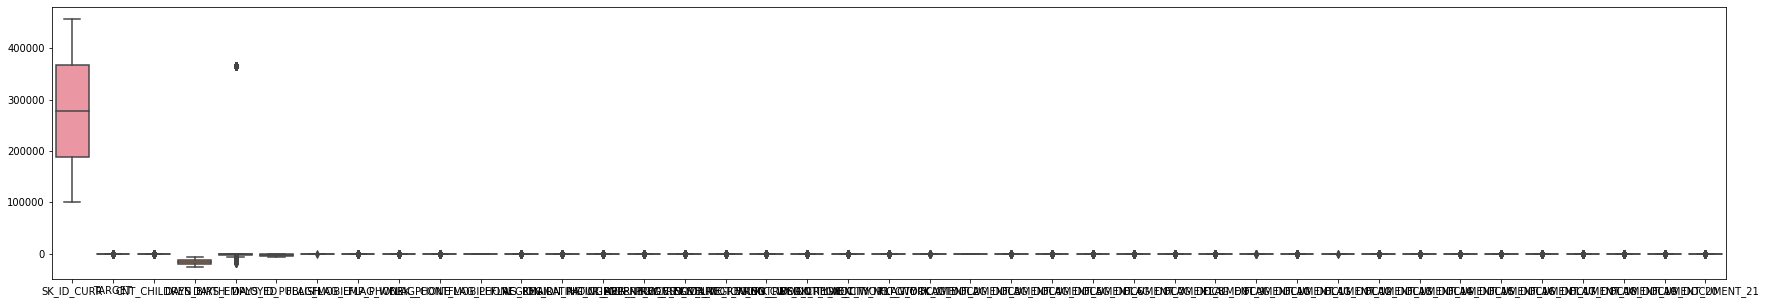

In [ ]:
plt.figure(figsize=(30,5))
sns.boxplot(data=data1.select_dtypes('int'))
plt.show()

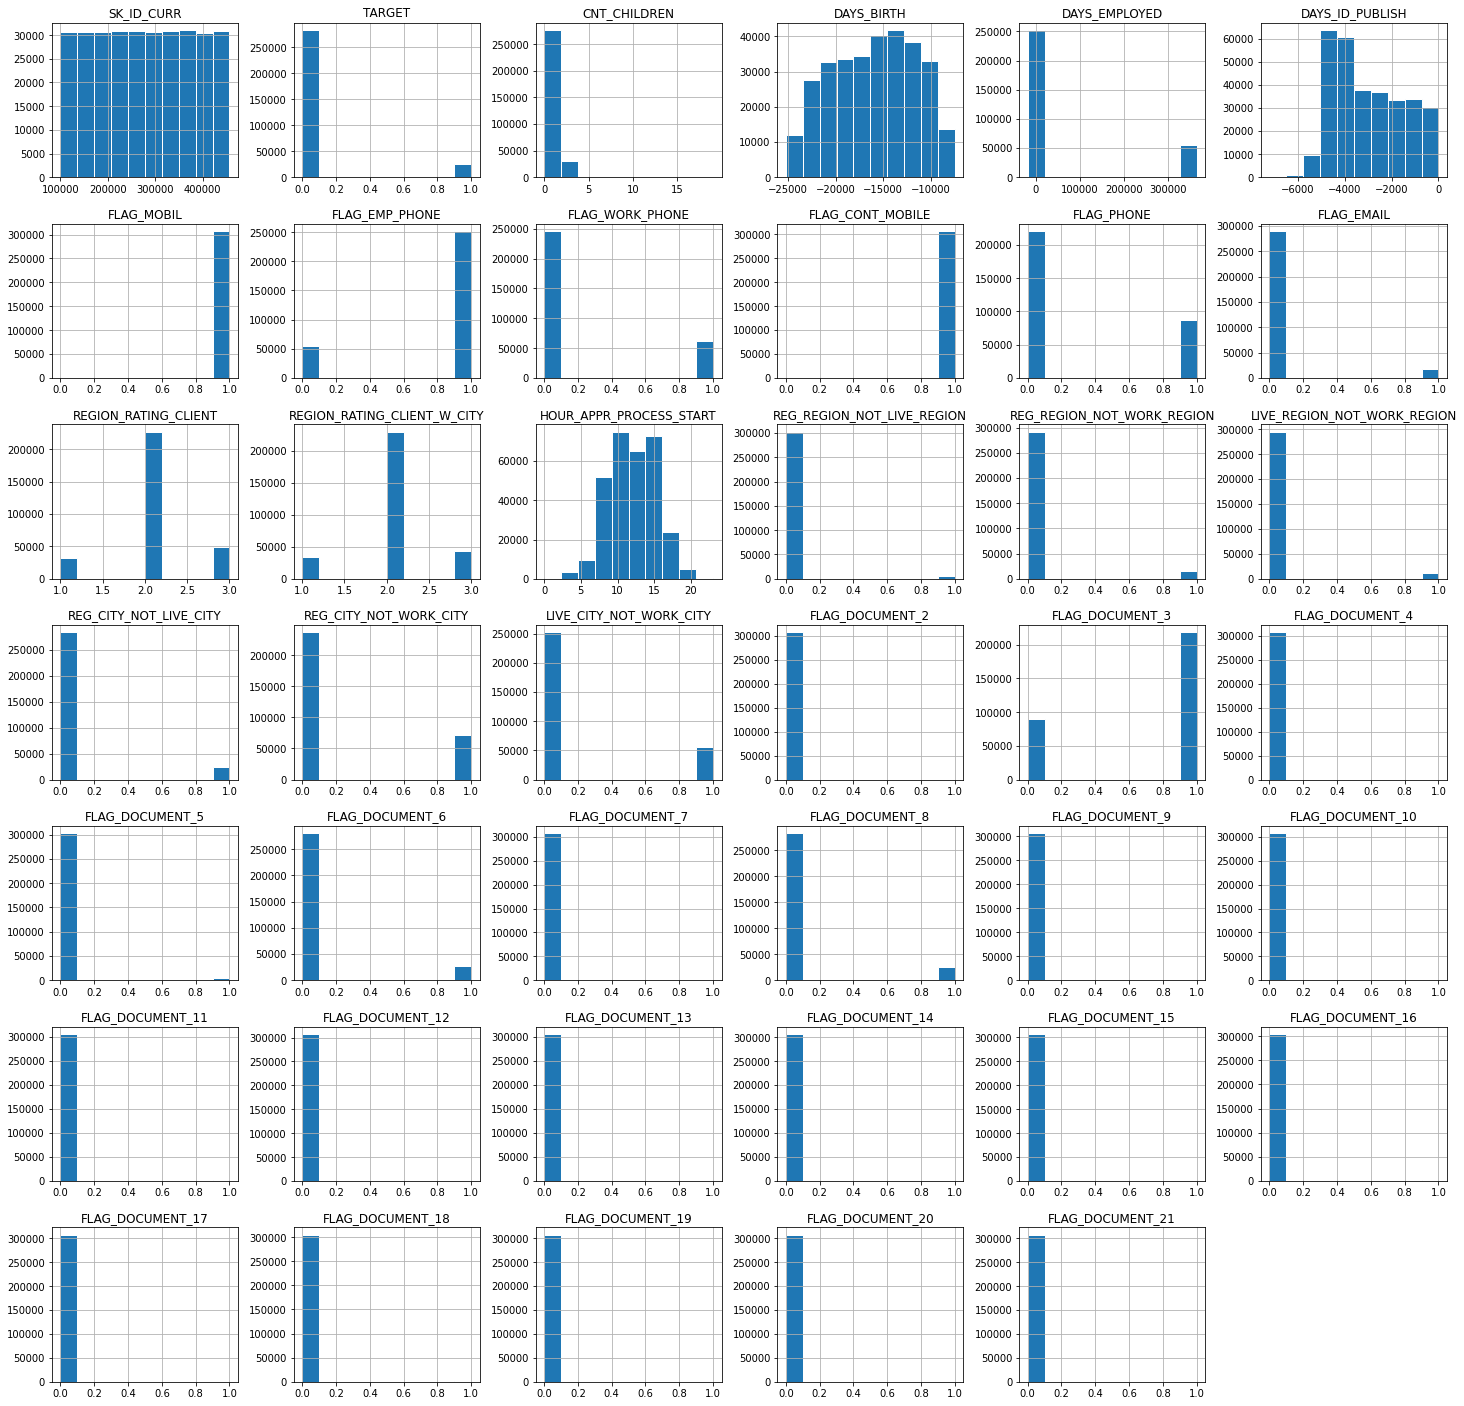

In [ ]:
data1.select_dtypes('int').hist(figsize=(25,25), ec='w')
plt.show()

In [ ]:
def color_(value):
    if value < 0 :
        color = 'red'
    elif value == 1 :
        color = 'blue'
    else:
        color = 'green'
    return 'color: %s' % color
data1.select_dtypes('int').corr().style.applymap(color_)

,SK_ID_CURR,TARGET,CNT_CHILDREN,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
SK_ID_CURR,1.000000,-0.002108,-0.001129,-0.001500,0.001366,-0.000384,0.002804,-0.001337,-0.000415,0.002815,0.002753,0.000281,-0.001075,-0.001138,0.000350,-0.000283,0.001097,0.002903,-0.001885,-0.001582,0.000067,0.000700,-0.003411,-0.004139,-0.001097,0.002121,-0.002694,0.001809,0.001505,-0.000815,-0.002012,-0.001045,0.000896,-0.001077,0.002604,-0.000724,0.001450,0.000509,0.000167,0.001073,0.000282
TARGET,-0.002108,1.000000,0.019187,0.078239,-0.044932,0.051457,0.000534,0.045982,0.028524,0.000370,-0.023806,-0.001758,0.058899,0.060893,-0.024166,0.005576,0.006942,0.002819,0.044395,0.050994,0.032518,0.005417,0.044346,-0.002672,-0.000316,-0.028602,-0.001520,-0.008040,-0.004352,-0.001414,-0.004229,-0.000756,-0.011583,-0.009464,-0.006536,-0.011615,-0.003378,-0.007952,-0.001358,0.000215,0.003709
CNT_CHILDREN,-0.001129,0.019187,1.000000,0.330938,-0.239818,-0.028019,0.001041,0.240714,0.055630,-0.000794,-0.029906,0.022619,0.025423,0.024781,-0.007292,-0.013319,0.008185,0.014835,0.020072,0.070650,0.069957,0.001786,0.056837,-0.003709,-0.016737,-0.157024,-0.001498,0.051697,-0.001997,-0.002756,-0.005318,0.000293,0.003945,-0.005459,0.003609,0.010662,0.000773,0.004031,0.000864,0.000988,-0.002450
DAYS_BIRTH,-0.001500,0.078239,0.330938,1.000000,-0.615864,0.272691,-0.003084,0.619888,0.172457,-0.014985,-0.042402,0.088208,0.009361,0.008073,0.091064,0.065486,0.095819,0.069567,0.180382,0.242401,0.158882,-0.001191,0.109666,-0.002789,0.016774,-0.407160,0.001469,0.113243,0.018213,-0.000168,0.044716,0.000236,0.026333,0.030733,0.012953,0.024044,0.007877,0.044498,0.003614,0.009015,0.027282
DAYS_EMPLOYED,0.001366,-0.044932,-0.239818,-0.615864,1.000000,-0.272378,0.000818,-0.999755,-0.233972,0.012745,0.015291,-0.062112,0.032750,0.034624,-0.091138,-0.035803,-0.107150,-0.095539,-0.090516,-0.254559,-0.218101,-0.003090,-0.249082,0.000437,-0.020041,0.597484,-0.002221,-0.121571,-0.023834,-0.000439,-0.028915,-0.001225,-0.025778,-0.023383,-0.014285,-0.042905,-0.007187,-0.040396,-0.010040,-0.010135,-0.008396
DAYS_ID_PUBLISH,-0.000384,0.051457,-0.028019,0.272691,-0.272378,1.000000,-0.002293,0.273611,0.045964,-0.000802,-0.037660,0.027505,-0.005103,-0.007737,0.031676,0.034757,0.048071,0.033938,0.076326,0.099354,0.061094,-0.000349,0.050309,0.000545,0.002066,-0.178282,-0.000034,0.024065,0.015271,-0.001214,0.022875,-0.002193,0.003048,0.008710,0.000158,0.002782,0.004804,0.014084,0.000903,0.000070,0.017246
FLAG_MOBIL,0.002804,0.000534,0.001041,-0.003084,0.000818,-0.002293,1.000000,-0.000845,0.000900,-0.000078,0.001128,0.000442,0.000186,0.000113,-0.000517,0.000224,0.000417,0.000371,0.000525,0.000987,0.000844,0.000012,0.002822,0.000016,0.000223,0.000560,0.000025,-0.006059,0.000113,0.000009,0.000113,0.000005,0.000107,0.000098,0.000063,0.000181,0.000029,-0.019919,0.000044,0.000041,0.000033
FLAG_EMP_PHONE,-0.001337,0.045982,0.240714,0.619888,-0.999755,0.273611,-0.000845,1.000000,0.233801,-0.012819,-0.016131,0.062542,-0.032871,-0.034712,0.091356,0.036640,0.108355,0.096447,0.092166,0.256427,0.219219,0.003047,0.248534,-0.000467,0.019778,-0.597732,0.001605,0.122043,0.023878,0.000463,0.029373,0.001195,0.025878,0.023559,0.014364,0.043008,0.007136,0.040548,0.010049,0.010183,0.008579
FLAG_WORK_PHONE,-0.000415,0.028524,0.055630,0.172457,-0.233972,0.045964,0.000900,0.233801,1.000000,0.021580,0.29

In [ ]:
data1.select_dtypes('int').cov().style.applymap(color_)

,SK_ID_CURR,TARGET,CNT_CHILDREN,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
SK_ID_CURR,10565820148.159863,-59.041266,-83.819815,-672773.474806,19840118.340063,-59637.043657,0.519822,-52.792950,-17.026415,12.488786,127.210825,6.675923,-56.230029,-58.787004,117.591486,-3.550655,24.765159,58.934592,-52.006771,-68.495018,2.649812,0.467797,-159.105827,-3.835537,-13.758077,61.789431,-3.835484,50.845908,9.635097,-0.399524,-12.911967,-0.274046,5.460625,-5.991139,9.303135,-7.376408,2.433360,4.698847,0.419252,2.482850,0.531302
TARGET,-59.041266,0.074212,0.003774,93.013383,-1729.246843,21.159315,0.000000,0.004814,0.003105,0.000004,-0.002915,-0.000111,0.008168,0.008340,-0.021500,0.000186,0.000415,0.000152,0.003247,0.005850,0.003400,0.000010,0.005482,-0.000007,-0.000010,-0.002208,-0.000006,-0.000599,-0.000074,-0.000002,-0.000072,-0.000001,-0.000187,-0.000140,-0.000062,-0.000314,-0.000015,-0.000195,-0.000009,0.000001,0.000018
CNT_CHILDREN,-83.819815,0.003774,0.521459,1042.893640,-24465.822569,-30.541355,0.000001,0.066797,0.016050,-0.000025,-0.009708,0.003778,0.009345,0.008997,-0.017197,-0.001175,0.001297,0.002116,0.003891,0.021485,0.019390,0.000008,0.018624,-0.000024,-0.001475,-0.032132,-0.000015,0.010207,-0.000090,-0.000009,-0.000240,0.000001,0.000169,-0.000213,0.000091,0.000763,0.000009,0.000261,0.000015,0.000016,-0.000032
DAYS_BIRTH,-672773.474806,93.013383,1042.893640,19044396.778354,-379696190.460693,1796274.604283,-0.024269,1039.548207,300.683368,-2.822582,-83.179638,89.039361,20.793917,17.712735,1297.854085,34.901210,91.795168,59.958770,211.315113,445.480226,266.122948,-0.033807,217.158095,-0.109750,8.931602,-503.514317,0.088816,135.118092,4.951212,-0.003499,12.181373,0.002628,6.810740,7.257161,1.964798,10.403174,0.561229,17.437894,0.384622,0.885874,2.178571
DAYS_EMPLOYED,19840118.340063,-1729.246843,-24465.822569,-379696190.460693,19958842205.453899,-58084280.383992,0.208475,-54276.179362,-13206.165065,77.720397,971.080210,-2029.700067,2355.208443,2459.141436,-42049.510410,-617.734580,-3323.126489,-2665.695206,-3432.789043,-15144.888706,-11826.318219,-2.838739,-15967.159919,0.556817,-345.446029,23919.779484,-4.346752,-4695.869363,-209.753185,-0.295962,-255.000541,-0.441518,-215.844983,-178.752631,-70.151202,-600.953661,-16.579148,-512.473665,-34.590424,-32.242815,-21.704477
DAYS_ID_PUBLISH,-59637.043657,21.159315,-30.541355,1796274.604283,-58084280.383992,2278440.567428,-0.006241,158.708853,27.719157,-0.052256,-25.553165,9.603124,-3.921112,-5.871592,156.151994,6.407188,15.928888,10.117304,30.927488,63.156146,35.395021,-0.003422,34.457608,0.007421,0.380569,-76.258727,-0.000712,9.931736,1.435942,-0.008743,2.155424,-0.008441,0.272714,0.711417,0.008264,0.416301,0.118405,1.909037,0.033225,0.002389,0.476338
FLAG_MOBIL,0.519822,0.000000,0.000001,-0.024269,0.208475,-0.006241,0.000003,-0.000001,0.000001,-0.000000,0.000001,0.000000,0.000000,0.000000,-0.000003,0.000000,0.000000,0.000000,0.000000,0.000001,0.000001,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,-0.000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000003,0.000000,0.000000,0.000000
FLAG_EMP_PHONE,-52.792950,0.004814,0.066797,1039.548207,-54276.179362,158.708853,-0.000001,0.147671,0.035895,-0.000213,-0.002786,0.005559,-0.006430,-0.006706,0.114652,0.001720,0.009141,0.007320,0.009508,0.041498,0.032333,0.000008,0.0

In [ ]:
print("___________________________________________________________________________________________")
print("float type values:",np.count_nonzero(data1.select_dtypes('float').columns))
print(data1.select_dtypes('float').columns)
print("___________________________________________________________________________________________")

___________________________________________________________________________________________
float type values: 65
Index(['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_REGISTRATION', 'OWN_CAR_AGE',
       'CNT_FAM_MEMBERS', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG',
       'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG',
       'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
       'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG',
       'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE',
       'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE',
       'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE',
       'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI',
       '

In [ ]:
missing(data1.select_dtypes('float'))

,Total,Percentage
COMMONAREA_MODE,214865,69.872297
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
LIVINGAPARTMENTS_MODE,210199,68.354953
LIVINGAPARTMENTS_MEDI,210199,68.354953
LIVINGAPARTMENTS_AVG,210199,68.354953
FLOORSMIN_MEDI,208642,67.848630


In [ ]:
data1 = data1.select_dtypes('float').interpolate(method ='linear', limit_direction ='forward')
missing(data1.select_dtypes('float'))

,Total,Percentage
OWN_CAR_AGE,2,0.000650


In [ ]:
data1 = data1.dropna(axis = 1)
missing(data1)

,Total,Percentage


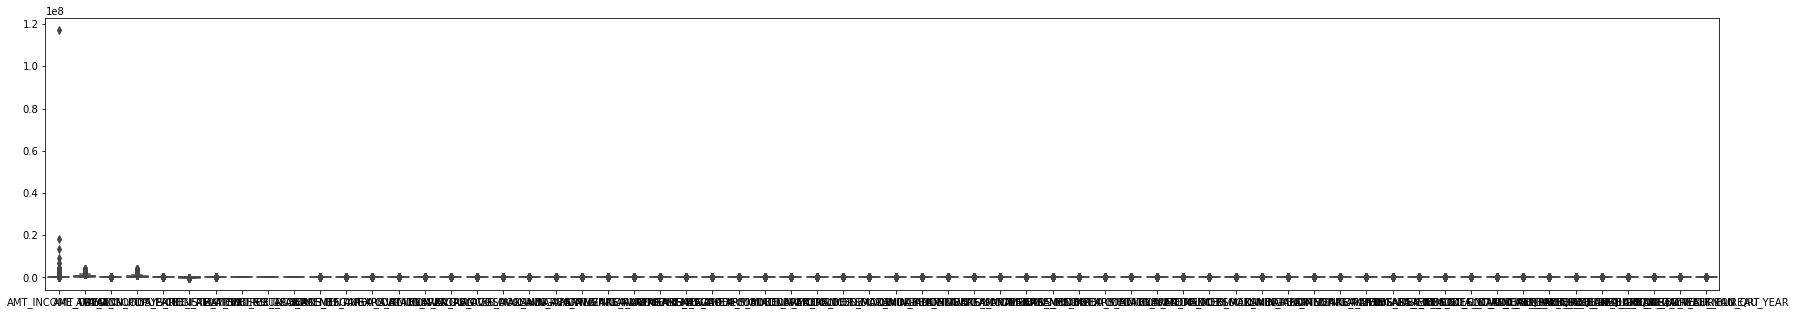

In [ ]:
plt.figure(figsize=(30,5))
sns.boxplot(data=data1.select_dtypes('float'))
plt.show()

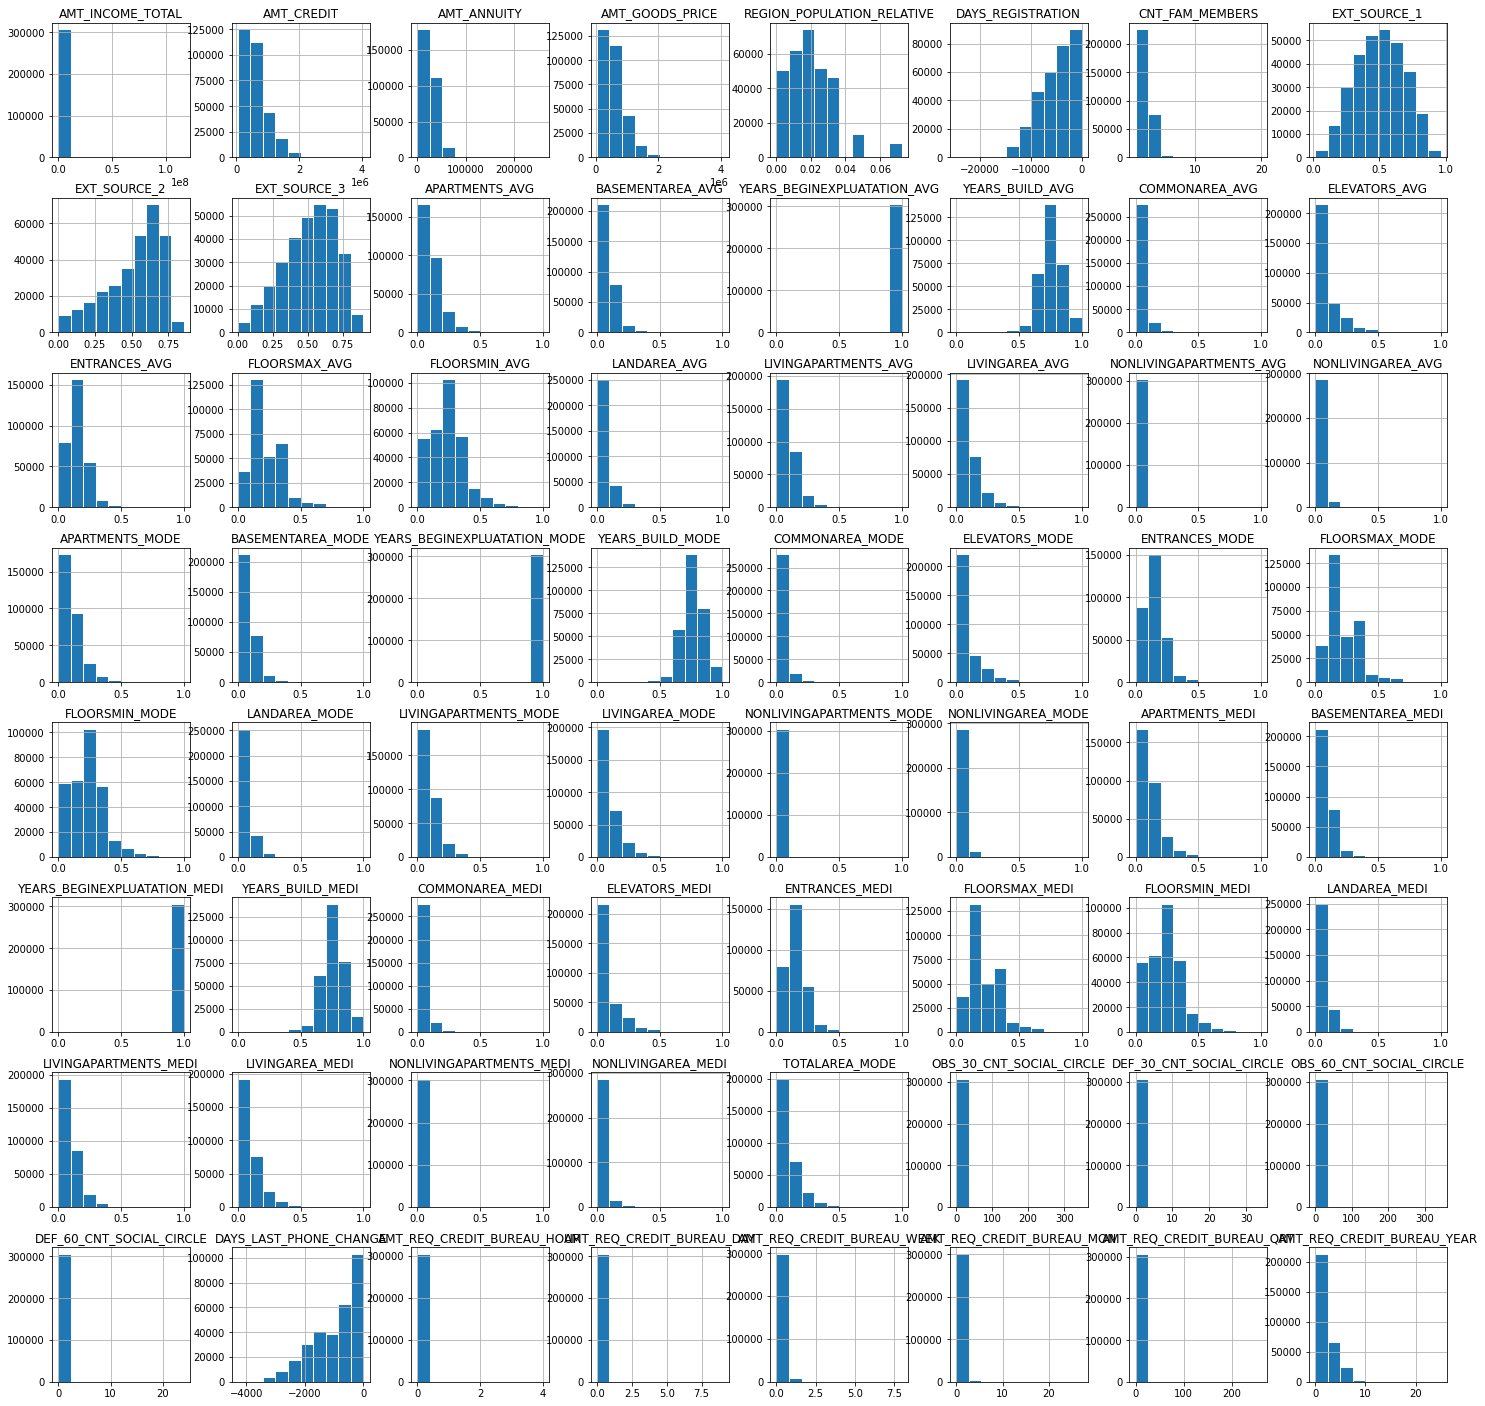

In [ ]:
data1.select_dtypes('float').hist(figsize=(25,25), ec='w')
plt.show()

In [ ]:
def color_(value):
    if value < 0 :
        color = 'red'
    elif value == 1 :
        color = 'blue'
    else:
        color = 'green'
    return 'color: %s' % color
data1.select_dtypes('float').corr().style.applymap(color_)

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
AMT_INCOME_TOTAL,1.000000,0.156870,0.191654,0.159579,0.074796,0.027805,0.016341,0.019347,0.060874,-0.027184,0.026665,0.012384,0.004476,0.006547,0.013675,0.033713,0.004892,0.046022,0.024548,-0.000877,0.018643,0.030778,0.005970,0.016631,0.023284,0.009294,0.003999,0.005608,0.011567,0.030772,0.002315,0.044156,0.023197,-0.002158,0.016310,0.027133,0.005178,0.013648,0.026098,0.011743,0.004513,0.006479,0.013440,0.033082,0.004489,0.045598,0.024296,-0.000961,0.018265,0.030268,0.005714,0.015792,0.032820,-0.013009,-0.013255,-0.012934,-0.013128,-0.018585,0.000745,0.002772,0.002254,0.023054,0.005542,0.010656
AMT_CREDIT,0.156870,1.000000,0.770114,0.986443,0.099738,0.009621,0.063160,0.088037,0.131032,0.037622,0.035398,0.018179,0.003291,0.017080,0.017721,0.043632,0.009782,0.061344,0.031846,0.001496,0.023239,0.043444,0.006996,0.019574,0.030756,0.014134,0.002204,0.015947,0.014777,0.039963,0.006118,0.058931,0.030470,-0.000068,0.019529,0.038812,0.006169,0.016376,0.034235,0.017294,0.002982,0.016967,0.017176,0.042639,0.008918,0.060869,0.031650,0.001335,0.022293,0.042657,0.007004,0.018283,0.044558,0.000335,-0.021156,0.000378,-0.023689,-0.073699,-0.002853,0.003615,-0.001612,0.048893,0.014428,-0.045072
AMT_ANNUITY,0.191654,0.770114,1.000000,0.774544,0.118423,0.038526,0.075536,0.062724,0.125636,0.025633,0.043713,0.020242,0.007517,0.014885,0.020002,0.054663,0.008834,0.076872,0.039775,0.003429,0.028784,0.053086,0.008447,0.025756,0.037666,0.014869,0.007161,0.013380,0.016580,0.049661,0.004158,0.074143,0.037594,0.000974,0.024231,0.046900,0.006978,0.021225,0.042236,0.019240,0.007276,0.014678,0.019592,0.053516,0.007890,0.076063,0.039193,0.003185,0.027674,0.052159,0.008157,0.024322,0.054786,-0.011741,-0.022729,-0.011495,-0.023898,-0.063747,0.003756,0.001763,0.011991,0.034713,0.008887,-0.011102
AMT_GOODS_PRICE,0.159579,0.986443,0.774544,1.000000,0.103541,0.011579,0.061135,0.091833,0.139148,0.041117,0.038057,0.020346,0.003926,0.019496,0.017788,0.045271,0.011709,0.064631,0.032682,0.004901,0.024108,0.046549,0.007169,0.021925,0.033373,0.016252,0.002880,0.018329,0.014812,0.041682,0.008112,0.062162,0.031165,0.003217,0.020178,0.041889,0.006238,0.018637,0.036901,0.019436,0.003646,0.019368,0.017232,0.044325,0.010882,0.064147,0.032488,0.004740,0.023132,0.045752,0.007132,0.020629,0.047451,0.000473,-0.022168,0.000482,-0.024430,-0.076241,-0.002264,0.004152,-0.001279,0.050632,0.014922,-0.047425
REGION_POPULATION_RELATIVE,0.074796,0.099738,0.118423,0.103541,1.000000,-0.053820,-0.024208,0.052488,0.198619,-0.004944,0.128705,0.053701,-0.005512,-0.026411,0.068040,0.169867,0.022417,0.206065,0.132545,-0.027712,0.084688,0.134060,0.011430,0.042897,0.109296,0.035500,-0.005562,-0.030020,0.053990,0.152105,0.009012,0.193897,0.123936,-0.032872,0.070763,0.113306,0.008897,0.027864,0.125861,0.051311,-0.005619,-0.027014,

In [ ]:
data1.select_dtypes('float').cov().style.applymap(color_)

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
AMT_INCOME_TOTAL,56227386501.183777,14971679825.343002,658667380.757526,13976263340.389439,245.308712,23227477.052352,3528.741611,843.548080,2756.342266,-1195.347476,604.493095,210.641602,55.341966,149.440230,209.575214,942.440604,102.218269,1399.353159,799.368248,-14.666170,347.386443,712.533323,56.708696,239.406313,525.766398,161.495970,53.917366,124.431222,173.422732,845.255641,48.784067,1334.033266,754.590723,-36.316510,321.382405,635.235524,47.424844,198.453412,596.024508,199.001841,56.512595,146.294669,206.226069,924.142968,94.087043,1391.035503,793.947861,-16.251670,344.241424,711.671683,53.585485,229.265486,741.366229,-7399.946631,-1402.956806,-7292.482680,-1126.937114,-3643612.308641,14.379705,70.567169,105.706297,4837.641640,993.357648,4567.314188
AMT_CREDIT,14971679825.343002,161998825566.727020,4492476211.574436,146645358280.266663,555.237032,13642359.041591,23150.526516,6515.537285,10070.774076,2807.981460,1362.079400,524.832170,69.076318,661.783404,460.997520,2070.357556,346.905444,3166.030170,1760.244257,42.448698,735.027714,1707.167743,112.808885,478.293551,1178.823602,416.884692,50.442023,600.629124,376.042349,1863.218209,218.838175,3022.047558,1682.398656,-1.944907,653.172249,1542.340396,95.908714,404.169770,1327.120917,497.476332,63.387126,650.265039,447.370769,2021.788506,317.303265,3151.886858,1755.599415,38.326861,713.149126,1702.422295,111.487140,450.554621,1708.418635,323.496663,-3800.836745,361.978276,-3451.649959,-24525685.881555,-93.427583,156.216961,-128.331310,17414.796177,4389.867086,-32789.644854
AMT_ANNUITY,658667380.757526,4492476211.574436,210063031.722209,4146305976.380744,23.739595,1967120.141947,996.991367,167.162385,347.711269,68.892648,60.570152,21.044050,5.681053,20.768701,18.736933,93.400566,11.282360,142.867318,79.167870,3.503295,32.783227,75.117337,4.904687,22.661815,51.986690,15.792940,5.900814,18.146240,15.193336,83.376391,5.355412,136.915276,74.748911,1.002171,29.182937,67.113181,3.906516,18.863622,58.957227,19.928754,5.568802,20.257828,18.375436,91.374183,10.107822,141.830770,78.284592,3.291737,31.878722,74.959199,4.675575,21.582820,75.641949,-408.226714,-147.042770,-396.137548,-125.388355,-763907.220323,4.428060,2.743954,34.372537,445.229105,97.371835,-290.826057
AMT_GOODS_PRICE,13976263340.389439,146645358280.266663,4146305976.380744,136420970802.272598,528.949758,15065987.088660,20563.591335,6236.906289,9814.051101,2816.161086,1343.824622,539.042357,75.615804,693.209734,424.632824,1971.279065,381.068025,3061.053252,1657.692890,127.601559,699.705569,1678.562478,106.080752,491.609660,1173.823168,439.892942,60.482874,633.487289,345.905534,1783.366871,266.258497,2925.280133,1579.108320,84.322845,619.315916,1527.566428,88.987964,422.109868,1312.697322,513.046219,71.101311,681.171710,411.869586,1928.667584,355.

In [ ]:
data = data.interpolate(method ='linear', limit_direction ='forward')
data = data.dropna(axis = 1)
missing(data)

,Total,Percentage


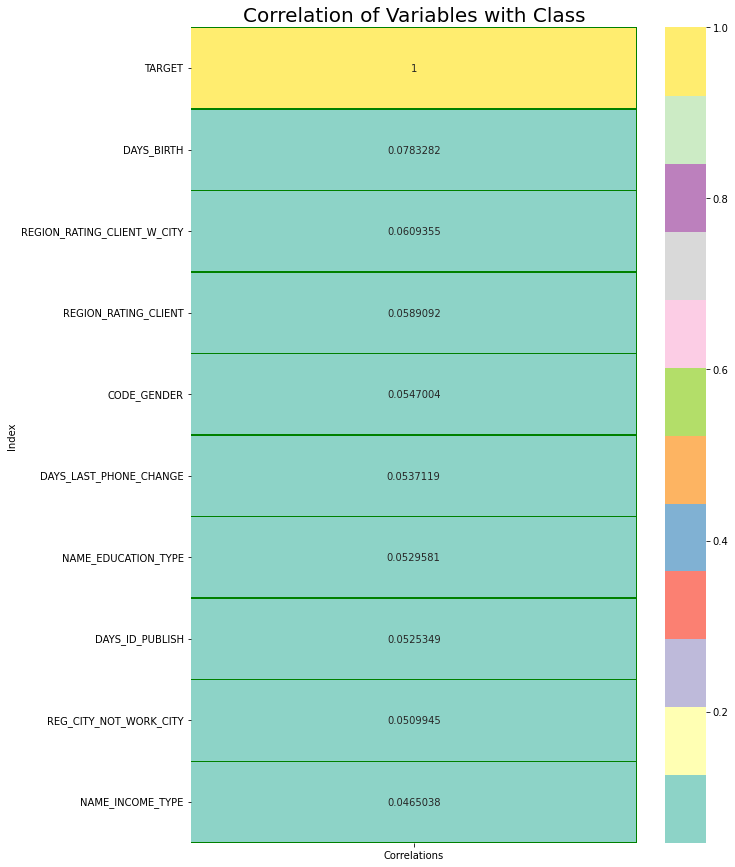

In [ ]:
corr = data.corrwith(data['TARGET'],method='spearman').reset_index()

corr.columns = ['Index','Correlations']
corr = corr.set_index('Index')
corr = corr.sort_values(by=['Correlations'], ascending = False).head(10)

plt.figure(figsize=(10, 15))
fig = sns.heatmap(corr, annot=True, fmt="g", cmap='Set3', linewidths=0.4, linecolor='green')

plt.title("Correlation of Variables with Class", fontsize=20)
plt.show()

### Building Classification Model

After the EDA, we build 3 baseline classification model and compare which model gives better accuracy.

1. Logistic Regression
2. K-Nearest Classifier
3. Decision Tree
4. Naive Bayes

In [ ]:
X = data.drop(['TARGET'],axis = 1)
target = data['TARGET']
X_train, X_test, Y_train, Y_test = train_test_split(X, target, test_size= 0.3, random_state = 0)

In [ ]:
def ml_model(X_train,X_test, Y_train, Y_test):
  MLA = [LogisticRegression(),KNeighborsClassifier(),DecisionTreeClassifier(),GaussianNB()]
  MLA_columns = []
  MLA_compare = pd.DataFrame(columns = MLA_columns)
  row_index = 0
  for alg in MLA:
    predicted = alg.fit(X_train, Y_train).predict(X_test)
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index,'Model Name'] = MLA_name
    MLA_compare.loc[row_index, 'Train Accuracy'] = round(alg.score(X_train, Y_train), 2)
    MLA_compare.loc[row_index, 'Test Accuracy'] = round(alg.score(X_test, Y_test), 2)
    MLA_compare.loc[row_index, 'Precision'] = round(precision_score(Y_test, predicted),2)
    MLA_compare.loc[row_index, 'Recall'] = round(recall_score(Y_test, predicted),2)
    MLA_compare.loc[row_index, 'F1 score'] = round(f1_score(Y_test, predicted),2)
    row_index+=1
  MLA_compare.sort_values(by = ['Test Accuracy'], ascending = False, inplace = True)    
  return MLA_compare  
ml_model(X_train,X_test, Y_train, Y_test)

,Model Name,Train Accuracy,Test Accuracy,Precision,Recall,F1 score
0,LogisticRegression,0.92,0.92,0.00,0.00,0.00
1,KNeighborsClassifier,0.92,0.91,0.12,0.01,0.02
3,GaussianNB,0.91,0.91,0.05,0.00,0.01
2,DecisionTreeClassifier,1.00,0.85,0.12,0.15,0.14


### Selecting 10 best features

Here we use Kbest select methodto find out the top 10 best features.

In [ ]:
from sklearn.feature_selection import SelectKBest,mutual_info_classif
bestfeatures = SelectKBest(score_func=mutual_info_classif, k=10)
fit = bestfeatures.fit(X,target,)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns) 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score'] 
print(featureScores.nlargest(10,'Score'))

                        Feature     Score
20                   FLAG_MOBIL  0.065662
23             FLAG_CONT_MOBILE  0.065165
21               FLAG_EMP_PHONE  0.045164
12          NAME_EDUCATION_TYPE  0.044518
10              NAME_TYPE_SUITE  0.043003
14            NAME_HOUSING_TYPE  0.041078
28         REGION_RATING_CLIENT  0.039379
29  REGION_RATING_CLIENT_W_CITY  0.039068
95              FLAG_DOCUMENT_3  0.032920
4               FLAG_OWN_REALTY  0.030868


In [ ]:
X = data[['FLAG_CONT_MOBILE','FLAG_MOBIL','FLAG_EMP_PHONE','NAME_TYPE_SUITE','NAME_EDUCATION_TYPE','NAME_HOUSING_TYPE','REGION_RATING_CLIENT_W_CITY','REGION_RATING_CLIENT',
         'FLAG_DOCUMENT_3','FLAG_OWN_REALTY']]
X_train, X_test, Y_train, Y_test = train_test_split(X, target, test_size= 0.3, random_state = 0)
Feature_selection = ml_model(X_train,X_test, Y_train, Y_test)
Feature_selection

,Model Name,Train Accuracy,Test Accuracy,Precision,Recall,F1 score
0,LogisticRegression,0.92,0.92,0.00,0.00,0.00
1,KNeighborsClassifier,0.92,0.92,0.18,0.01,0.01
2,DecisionTreeClassifier,0.92,0.92,0.05,0.00,0.00
3,GaussianNB,0.24,0.24,0.09,0.90,0.16


In [ ]:
print('before Oversampling:',Counter(Y_train))
oversample = RandomOverSampler(sampling_strategy='minority')
X_train1, Y_train1 = oversample.fit_resample(X_train, Y_train)
print('After Oversampling:',Counter(Y_train1))

before Oversampling: Counter({0: 197772, 1: 17485})
After Oversampling: Counter({0: 197772, 1: 197772})


Counter({0: 282686, 1: 24825})


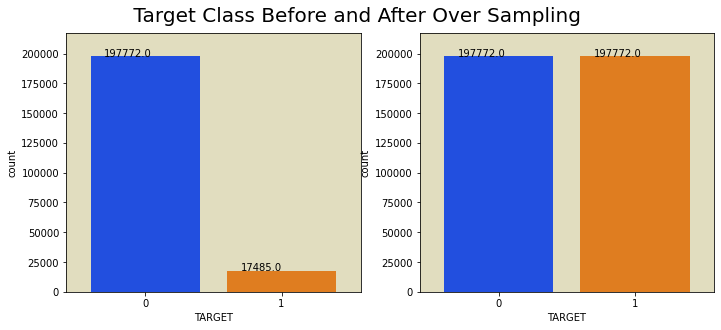

In [ ]:
print(Counter(target))
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,4.5))
fig.subplots_adjust(bottom=0.10, left=0.10, top = 0.900, right=1.00)
fig.suptitle(' Target Class Before and After Over Sampling', fontsize = 20)
sns.set_palette("bright")
sns.countplot(Y_train, ax=ax1)
ax1.margins(0.1)
ax1.set_facecolor("#e1ddbf")
for p in ax1.patches:
        ax1.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
sns.set_palette("bright")
sns.countplot(Y_train1, ax=ax2)
ax2.margins(0.1)
ax2.set_facecolor("#e1ddbf")
for p in ax2.patches:
        ax2.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
sns.set_style('dark')

In [ ]:
oversampling = ml_model(X_train1,X_test, Y_train1, Y_test)
oversampling

,Model Name,Train Accuracy,Test Accuracy,Precision,Recall,F1 score
1,KNeighborsClassifier,0.52,0.89,0.14,0.07,0.09
2,DecisionTreeClassifier,0.59,0.54,0.10,0.61,0.18
0,LogisticRegression,0.58,0.53,0.10,0.63,0.18
3,GaussianNB,0.50,0.08,0.08,1.00,0.15


In [ ]:
print('before SMOTE:',Counter(Y_train))
sm = SMOTE(sampling_strategy='minority')
X_train2, Y_train2 = sm.fit_resample(X_train, Y_train)
print('After SMOTE:',Counter(Y_train2))

before SMOTE: Counter({0: 197772, 1: 17485})
After SMOTE: Counter({0: 197772, 1: 197772})


In [ ]:
Smote = ml_model(X_train2,X_test, Y_train2, Y_test)
Smote

,Model Name,Train Accuracy,Test Accuracy,Precision,Recall,F1 score
1,KNeighborsClassifier,0.50,0.92,0.13,0.01,0.01
2,DecisionTreeClassifier,0.59,0.55,0.10,0.61,0.18
0,LogisticRegression,0.58,0.53,0.10,0.63,0.18
3,GaussianNB,0.50,0.08,0.08,1.00,0.15


In [ ]:
!pip install lightgbm

In [ ]:
def ensemble_model(X_train,X_test, Y_train, Y_test):
  class_weight={0:0.087, 1:1}
  MLA = [CatBoostClassifier(iterations=200, learning_rate=0.3,random_seed=42,task_type="GPU",verbose=False),XGBClassifier(n_estimators=200,learning_rate=0.1,
  tree_method = 'gpu_hist',random_state=42),LGBMClassifier(n_estimators=200,is_unbalance=True,learning_rate=0.1,
     class_weight=class_weight,num_leaves=200,device='gpu',random_state=42,n_jobs=-1)]
  MLA_columns = []
  MLA_compare = pd.DataFrame(columns = MLA_columns)
  row_index = 0
  for alg in MLA:
    predicted = alg.fit(X_train, Y_train).predict(X_test)
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index,'Model Name'] = MLA_name
    MLA_compare.loc[row_index, 'Train Accuracy'] = round(alg.score(X_train, Y_train), 2)
    MLA_compare.loc[row_index, 'Test Accuracy'] = round(alg.score(X_test, Y_test), 2)
    MLA_compare.loc[row_index, 'Precision'] = round(precision_score(Y_test, predicted),2)
    MLA_compare.loc[row_index, 'Recall'] = round(recall_score(Y_test, predicted),2)
    MLA_compare.loc[row_index, 'F1 score'] = round(f1_score(Y_test, predicted),2)
    row_index+=1
  MLA_compare.sort_values(by = ['Test Accuracy'], ascending = False, inplace = True)    
  return MLA_compare  
ensemble_model(X_train,X_test, Y_train, Y_test)

LightGBMError: ignored